<font color=red>Load packages</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist,euclidean
from scipy.spatial import KDTree,Delaunay
from scipy.linalg import eigh,inv,norm
from scipy.interpolate import RBFInterpolator
from scipy.spatial.transform import Rotation as R
import open3d as o3d
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<font color=red>Load sph particles and delete too fast ones</font>

In [2]:
input_sph_path = 'D:/jiaoyf/Seafile/SPH/sphsol-para/Data/dart_simu/no-xsph/Particles0020.csv'
dist = 0.75
vmax = 0.5
mass = 1.0
omg = [0.0,0.0,0.0]

sph_particles = pd.read_csv(input_sph_path)
if "MASS" not in sph_particles.columns: sph_particles["MASS"] = mass
sph_particles["R"] = 0.5 * dist

# add an initial rotation: omg cross pos
sph_particles["VX"] += omg[1] * sph_particles["Z"] - omg[2] * sph_particles["Y"]
sph_particles["VY"] += omg[2] * sph_particles["X"] - omg[0] * sph_particles["Z"]
sph_particles["VZ"] += omg[0] * sph_particles["Y"] - omg[1] * sph_particles["X"]

# remove fast particles
sph_particles["VMOD2"] = sph_particles["VX"]*sph_particles["VX"] + sph_particles["VY"]*sph_particles["VY"] + sph_particles["VZ"]*sph_particles["VZ"]
sph_particles = sph_particles[~((sph_particles.FRAG == -1) & (sph_particles.VMOD2 >= vmax*vmax))]

# initial bed id
sph_particles["BEDID"] = -100

print(sph_particles.columns)

Index(['ID', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'P', 'MASS', 'D', 'FRAG',
       'SUB_FRAG', 'R12', 'R13', 'R23', 'R', 'VMOD2', 'BEDID'],
      dtype='object')


<font color=red>Assign sph particles to bed particles</font>

In [3]:
input_bed_path = 'D:/jiaoyf/Seafile/SPH/sphsol-para/Data/dart_simu/final_bed.csv'
bed_particles = pd.read_csv(input_bed_path)
bed_particles *= 0.9

# query the nearest bed particle for each sph particle
sph_xyz = sph_particles[["X","Y","Z"]].values
bed_xyz = bed_particles[["X","Y","Z"]].values
bed_tree = KDTree(bed_xyz)
dd,ii = bed_tree.query(sph_xyz, k=1)
sph_particles["BEDID"] = ii

# dertermine all bed particles' fragment id by the most frequent sph particle
bed_particles["FRAG"] = -100
grouped_frags = sph_particles.groupby("BEDID")["FRAG"].agg(lambda x: x.value_counts().index[0])
bed_particles.loc[grouped_frags.index.values,"FRAG"] = grouped_frags.values
# note that only the bed particles with FRAG not -100 are valid
bed_particles = bed_particles[bed_particles.FRAG != -100]

In [4]:
print(len(bed_particles))
print(min(bed_particles.R),max(bed_particles.R))

336163
0.6750013410000001 1.3499983800000002


<font color=red>Calculate all individual bed particles</font>

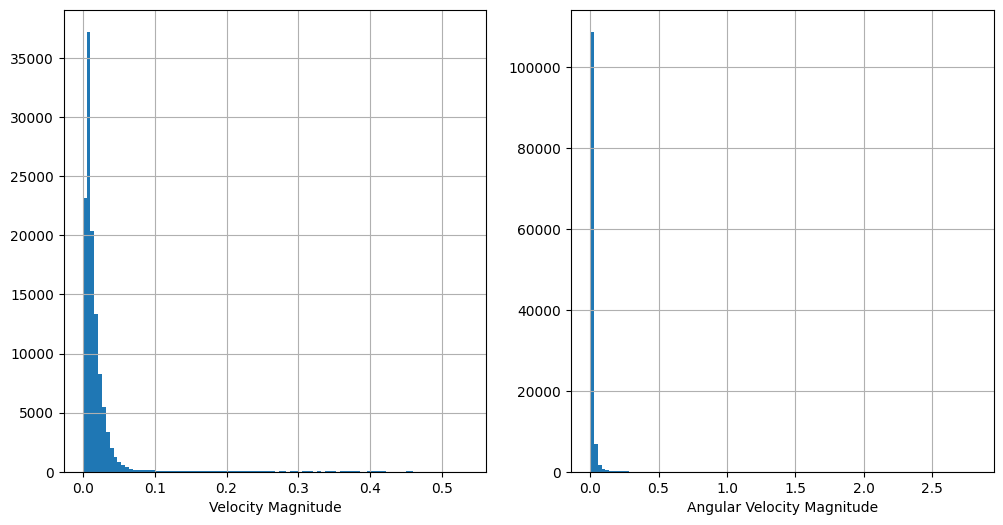

In [5]:
idd_bed_particles = bed_particles[bed_particles.FRAG == -1].copy()
idd_sph_particles = sph_particles[sph_particles.BEDID.isin(idd_bed_particles.index.values)].copy()

# dertermine idd_bed_particles' mass as a total of all idd_sph_particles with the same bed id
grouped_mass = idd_sph_particles.groupby("BEDID")["MASS"].sum()
idd_bed_particles.loc[grouped_mass.index.values,"MASS"] = grouped_mass.values

# inertia of idd_bed_particles
idd_bed_particles['IXX'] = 2./5.*idd_bed_particles['R']*idd_bed_particles['R']*idd_bed_particles['MASS']
idd_bed_particles['IYY'] = idd_bed_particles['IXX']
idd_bed_particles['IZZ'] = idd_bed_particles['IXX']
idd_bed_particles['IXY'] = 0.0
idd_bed_particles['IXZ'] = 0.0
idd_bed_particles['IYZ'] = 0.0

# momentum of idd_sph_particles
idd_sph_particles[['PX','PY','PZ']] = idd_sph_particles[['VX','VY','VZ']].mul(idd_sph_particles['MASS'],axis=0)
# dertermine idd_bed_particles' momentum as a total of all idd_sph_particles with the same bed id
grouped_px = idd_sph_particles.groupby("BEDID")["PX"].sum()
grouped_py = idd_sph_particles.groupby("BEDID")["PY"].sum()
grouped_pz = idd_sph_particles.groupby("BEDID")["PZ"].sum()
idd_bed_particles.loc[grouped_px.index.values,"PX"] = grouped_px.values
idd_bed_particles.loc[grouped_py.index.values,"PY"] = grouped_py.values
idd_bed_particles.loc[grouped_pz.index.values,"PZ"] = grouped_pz.values
idd_bed_particles[['VX','VY','VZ']] = idd_bed_particles[['PX','PY','PZ']].div(idd_bed_particles['MASS'],axis=0)

# dertermine idd_bed_particles' angular momentum as a total of ([X,Y,Z] cross [PX,PY,PZ]) of all idd_sph_particles with the same bed id
grouped_lx = idd_sph_particles.groupby("BEDID").apply(lambda x: (x['Y']*x['PZ']-x['Z']*x['PY']).sum())
grouped_ly = idd_sph_particles.groupby("BEDID").apply(lambda x: (x['Z']*x['PX']-x['X']*x['PZ']).sum())
grouped_lz = idd_sph_particles.groupby("BEDID").apply(lambda x: (x['X']*x['PY']-x['Y']*x['PX']).sum())
idd_bed_particles.loc[grouped_lx.index.values,"LX"] = grouped_lx.values
idd_bed_particles.loc[grouped_ly.index.values,"LY"] = grouped_ly.values
idd_bed_particles.loc[grouped_lz.index.values,"LZ"] = grouped_lz.values
# the above is for the original coordinate, move to the center of idd_bed_particles, like Lc = Lo - r cross p
idd_bed_particles['LX'] -= idd_bed_particles['Y']*idd_bed_particles['PZ'] - idd_bed_particles['Z']*idd_bed_particles['PY']
idd_bed_particles['LY'] -= idd_bed_particles['Z']*idd_bed_particles['PX'] - idd_bed_particles['X']*idd_bed_particles['PZ']
idd_bed_particles['LZ'] -= idd_bed_particles['X']*idd_bed_particles['PY'] - idd_bed_particles['Y']*idd_bed_particles['PX']
idd_bed_particles[['OMGX','OMGY','OMGZ']] = idd_bed_particles[['LX','LY','LZ']].div(idd_bed_particles['IXX'],axis=0)

# plot the idd_bed_particles's histogram of velocity maginitude and angular velocity magnitude
idd_bed_particles["VMOD2"] = idd_bed_particles["VX"]*idd_bed_particles["VX"] + idd_bed_particles["VY"]*idd_bed_particles["VY"] + idd_bed_particles["VZ"]*idd_bed_particles["VZ"]
idd_bed_particles["OMG2"] = idd_bed_particles["OMGX"]*idd_bed_particles["OMGX"] + idd_bed_particles["OMGY"]*idd_bed_particles["OMGY"] + idd_bed_particles["OMGZ"]*idd_bed_particles["OMGZ"]
idd_bed_particles["VMOD"] = np.sqrt(idd_bed_particles["VMOD2"])
idd_bed_particles["OMG"] = np.sqrt(idd_bed_particles["OMG2"])
# plot as subplot
fig, axes = plt.subplots(1,2,figsize=(12,6))
idd_bed_particles["VMOD"].hist(bins=100,ax=axes[0])
idd_bed_particles["OMG"].hist(bins=100,ax=axes[1])
axes[0].set_xlabel("Velocity Magnitude")
axes[1].set_xlabel("Angular Velocity Magnitude")
plt.show()

<font color=red>Calculate all rigid bed particle clusters</font>

In [6]:
def edt(particles, edge_particles):
  # memory limit set to 10 G
  ulimit = 10.0 * pow(1024.0, 3.0) / 8.0
  max_inner_num = int(ulimit / len(edge_particles.index))

  if max_inner_num > len(particles.index):
    # euclidean distance map to edge of each inner particle
    dist_ = cdist(particles[["X","Y","Z"]], edge_particles[["X","Y","Z"]], "euclidean")
    # add known dist_edge to dist
    dist_ = np.hstack((dist_, np.array(particles["DIST_EDGE"])[:,np.newaxis]))
    dist_ = np.min(dist_, axis=1)
    particles["DIST_EDGE"] = dist_
    # particle with the max euclidean distance
    center = particles.iloc[[np.argmax(dist_)]] #.to_frame()
  else:
    batch_num = int(np.ceil(len(particles.index) / max_inner_num))
    indices_list = np.array(range(len(particles.index)))
    for i in range(batch_num):
      batch_particles_indices = indices_list[np.where((indices_list+i)%batch_num==0)]
      batch_particles = particles.iloc[batch_particles_indices]
      dist_ = cdist(batch_particles[["X","Y","Z"]], edge_particles[["X","Y","Z"]], "euclidean")
      dist_ = np.hstack((dist_, np.array(batch_particles["DIST_EDGE"])[:,np.newaxis]))
      dist_ = np.min(dist_, axis=1)
      particles.iloc[batch_particles_indices, particles.columns.get_loc("DIST_EDGE")] = dist_
    center = particles.iloc[[particles["DIST_EDGE"].argmax()]]

  radius = np.max(dist_)

  return center, radius, particles

In [7]:
class dem_cluster():
  def __init__(self, hash):
    self.hash = hash
    self.edge_particles = pd.DataFrame(columns=['X','Y','Z','R'])
    self.grav_particles = pd.DataFrame(columns=['X','Y','Z','R','MASS'])
    self.mass = 0.
    self.pos  = np.zeros(3)
    self.vel  = np.zeros(3)
    self.omg  = np.zeros(3)
    self.J    = np.zeros((3,3))
    self.quat = np.array([0.0,0.0,0.0,1.0])
    self.pi   = np.zeros(3)

  # set the edge particles from the bed particles
  def add_edge_particles(self,particles):
    particles = particles.copy()
    alpha=2.5*max(particles['R'])

    # multi layers
    for layer in [1,2,3]:
      # drop the mesh particles from particles
      if layer>1: particles.drop(mesh_particles.IDX, inplace=True)
      # add the surface particles using the o3d alpha shape with alpha of double max radius
      if len(particles.index) <= 4:
        self.edge_particles = pd.concat([self.edge_particles, particles[['X','Y','Z','R']]], ignore_index=True)
        break
      xyz = np.array(particles[["X","Y","Z"]])
      pcd = o3d.geometry.PointCloud()
      pcd.points = o3d.utility.Vector3dVector(xyz)
      mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha=alpha)
      mesh_particles = pd.DataFrame(np.asarray(mesh.vertices),columns=['X','Y','Z'])
      # find the mesh particles' radius as the same of the bed particles whose pos is the same
      mesh_particles['R'] = 0.0
      mesh_particles['IDX'] = 0
      for i in range(len(mesh_particles)):
        mesh_particles.loc[i,'R'] = particles[(particles['X']==mesh_particles.loc[i,'X']) & (particles['Y']==mesh_particles.loc[i,'Y']) & (particles['Z']==mesh_particles.loc[i,'Z'])]['R'].values[0]
        mesh_particles.loc[i,'IDX'] = particles[(particles['X']==mesh_particles.loc[i,'X']) & (particles['Y']==mesh_particles.loc[i,'Y']) & (particles['Z']==mesh_particles.loc[i,'Z'])].index.values[0]
      # add the mesh particles to the edge particles
      self.edge_particles = pd.concat([self.edge_particles, mesh_particles[['X','Y','Z','R']]], ignore_index=True)

  # set the grav particles and other parameters from the sph particles
  def add_grav_particles(self,particles):
    particles  = particles.copy()
    alpha = 5.0*max(particles['R'])
    rmin = 1.0*max(particles['R'])
    dist = 2.0*max(particles['R'])

    # other parameters
    self.mass = particles['MASS'].sum()
    # center of mass
    self.pos  = particles[['X','Y','Z']].mul(particles['MASS'],axis=0).sum()/self.mass
    self.vel  = particles[['VX','VY','VZ']].mul(particles['MASS'],axis=0).sum()/self.mass
    # angular momentum
    Lox = (particles["Y"] * particles["VZ"] - particles["Z"] * particles["VY"]) * particles["MASS"]
    Loy = (particles["Z"] * particles["VX"] - particles["X"] * particles["VZ"]) * particles["MASS"]
    Loz = (particles["X"] * particles["VY"] - particles["Y"] * particles["VX"]) * particles["MASS"]
    # angular momentum to coordinate origin
    Lo = np.array([np.sum(Lox), np.sum(Loy), np.sum(Loz)])
    # angular momentum to center of mass, Lo = Lc + m*cross(r_oc,v_c)
    Lc = (Lo - self.mass * np.cross(self.pos, self.vel)).transpose()
    # rotational inertia tensor
    self.J = self.calc_inertia_tensor(particles, self.pos)
    # calc from Lc = J * omega
    self.omg = np.matmul(inv(self.J), Lc)
    # calc quaternion
    self.calc_quaternion()

    # generate edge sph particles
    xyz = np.array(particles[["X","Y","Z"]])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha=alpha)
    mesh_particles = pd.DataFrame(np.asarray(mesh.vertices),columns=['X','Y','Z'])

    # generate grav particles
    particles["DIST_EDGE"] = np.inf
    while len(particles.index) > 1:
      # calculate edt and find the max inner sphere
      center, radius, particles = edt(particles, mesh_particles)
      radius += 0.5*dist
      if radius <= rmin: break
      # quit loop if the biggest sphere includes only 1 particle
      dist_ = cdist(center[["X","Y","Z"]], particles[["X","Y","Z"]], "euclidean")
      sphere_indices = np.argwhere(dist_ <= radius)[:,-1]
      sphere_edge_indices = np.argwhere((dist_ > radius) & (dist_ <= radius + dist))[:,-1]
      if len(sphere_indices) < 1 or len(sphere_edge_indices) < 1: break
      # for all particles inside the sphere, record as a big dem particle
      sphere_particles = particles.iloc[sphere_indices]
      dem_particle = center.copy()
      dem_particle["R"] = radius
      dem_particle["MASS"] = np.sum(sphere_particles["MASS"])
      self.grav_particles = pd.concat([self.grav_particles, dem_particle[['X','Y','Z','R','MASS']]])
      # find sphere edge and add these particles into new edge
      mesh_particles = particles.iloc[sphere_edge_indices]
      # remove sphere particles from inner particles
      particles = particles.drop(index=sphere_particles.index)
    
    # mass check
    self.check()
  
  def calc_inertia_tensor(self, particles, center):
    pp = particles[["X","Y","Z","MASS","R"]].copy()
    pp.X -= center[0]
    pp.Y -= center[1]
    pp.Z -= center[2]
    Ic = (0.4 * pp.MASS * np.square(pp.R)).sum()
    I_xx = ((np.square(pp.Y) + np.square(pp.Z)) * pp.MASS).sum() + Ic
    I_yy = ((np.square(pp.X) + np.square(pp.Z)) * pp.MASS).sum() + Ic
    I_zz = ((np.square(pp.X) + np.square(pp.Y)) * pp.MASS).sum() + Ic
    I_xy = (-pp.X * pp.Y * pp.MASS).sum()
    I_xz = (-pp.X * pp.Z * pp.MASS).sum()
    I_yz = (-pp.Y * pp.Z * pp.MASS).sum()
    I = np.array([[I_xx, I_xy, I_xz], [I_xy, I_yy, I_yz], [I_xz, I_yz, I_zz]])
    return I

  def calc_quaternion(self):
    w, v = eigh(self.J)
    self.pi = w
    r = R.from_matrix(v)
    self.quat = r.as_quat()

  def check(self):
    coef = self.mass / sum(self.grav_particles.MASS)
    self.grav_particles.MASS *= coef

  def transform(self):
    # transfer all particles position into inertia coordinate
    r = R.from_quat(self.quat)
    A = (r.as_matrix()).transpose()
    for index in self.grav_particles.index:
      pos0 = np.array([self.grav_particles.loc[index,"X"], self.grav_particles.loc[index,"Y"], self.grav_particles.loc[index,"Z"]])
      pos0 -= self.pos
      pos1 = np.matmul(A,pos0)
      self.grav_particles.loc[index,"X"] = pos1[0]
      self.grav_particles.loc[index,"Y"] = pos1[1]
      self.grav_particles.loc[index,"Z"] = pos1[2]
    for index in self.edge_particles.index:
      pos0 = np.array([self.edge_particles.loc[index,"X"], self.edge_particles.loc[index,"Y"], self.edge_particles.loc[index,"Z"]])
      pos0 -= self.pos
      pos1 = np.matmul(A,pos0)
      self.edge_particles.loc[index,"X"] = pos1[0]
      self.edge_particles.loc[index,"Y"] = pos1[1]
      self.edge_particles.loc[index,"Z"] = pos1[2]

In [11]:
# Test only
cls_bed_particles = bed_particles[bed_particles.FRAG != -1].copy()
cls_sph_particles = sph_particles[sph_particles.BEDID.isin(cls_bed_particles.index.values)].copy()

dem_clusters = {}
key = 4
dem_clusters[key] = dem_cluster(key)
dem_clusters[key].add_edge_particles(cls_bed_particles[cls_bed_particles.FRAG == key])
dem_clusters[key].add_grav_particles(cls_sph_particles[cls_sph_particles.BEDID.isin(cls_bed_particles[cls_bed_particles.FRAG == key].index.values)])
# plot both the edge and grav particles in o3d
xyz = np.array(dem_clusters[key].edge_particles[["X","Y","Z"]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.paint_uniform_color([1, 0.706, 0])
xyz = np.array(dem_clusters[key].grav_particles[["X","Y","Z"]])
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(xyz)
pcd2.paint_uniform_color([0, 0.651, 0.929])
o3d.visualization.draw_geometries([pcd, pcd2])

dem_clusters[key].grav_particles.to_csv("grav_particles.csv",index=False)
dem_clusters[key].edge_particles.to_csv("edge_particles.csv",index=False)
cls_sph_particles[cls_sph_particles.BEDID.isin(cls_bed_particles[cls_bed_particles.FRAG == key].index.values)].to_csv("sph_particles.csv",index=False)

In [8]:
cls_bed_particles = bed_particles[bed_particles.FRAG != -1].copy()
cls_sph_particles = sph_particles[sph_particles.BEDID.isin(cls_bed_particles.index.values)].copy()

dem_clusters = {}
for key in sorted(cls_bed_particles.FRAG.unique()):
  dem_clusters[key] = dem_cluster(key)
  dem_clusters[key].add_edge_particles(cls_bed_particles[cls_bed_particles.FRAG == key])
  dem_clusters[key].add_grav_particles(cls_sph_particles[cls_sph_particles.BEDID.isin(cls_bed_particles[cls_bed_particles.FRAG == key].index.values)])

[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh


<font color=red>Tranform and Export</font>

In [9]:
def check_contact(dem_clusters_):
  # check particles contact
  dem_clusters = dem_clusters_.copy()
  rmax = max([(dem_clusters[key].edge_particles["R"]).max() for key in dem_clusters])
  rmin = min([(dem_clusters[key].edge_particles["R"]).min() for key in dem_clusters])
  total_num = sum([len(dem_clusters[key].edge_particles.index) for key in dem_clusters])
  print("  Edge particle radius in [%f, %f]" % (rmin, rmax))
  # add all particles into kdtree
  xyz = pd.DataFrame(columns=["X","Y","Z"])
  cluster_id = np.zeros(total_num,dtype=int)
  cum_num = 0
  for key in dem_clusters:
    xyz = pd.concat([xyz, dem_clusters[key].edge_particles[["X","Y","Z"]]])
    edge_num = len(dem_clusters[key].edge_particles.index)
    dem_clusters[key].edge_particles["PCDID"] = cum_num + np.array(range(edge_num),dtype=int)
    cluster_id[cum_num+np.array(range(edge_num),dtype=int)] = key
    cum_num += edge_num
  xyz = np.array(xyz)
  kd_tree = KDTree(xyz)

  # np.savetxt("./data/cluster_id.txt",cluster_id)
  pairs = kd_tree.query_pairs(r=rmax*2.0,output_type="ndarray")
  pairs = pairs[cluster_id[pairs[:,0]] != cluster_id[pairs[:,1]],:]
  for line in range(np.shape(pairs)[0]):
    i,j = pairs[line,0], pairs[line,1]
    ikey,jkey = cluster_id[i], cluster_id[j]
    dist = euclidean(xyz[i,:], xyz[j,:])
    ix = (dem_clusters[ikey].edge_particles[dem_clusters[ikey].edge_particles["PCDID"]==i]).index[0]
    jx = (dem_clusters[jkey].edge_particles[dem_clusters[jkey].edge_particles["PCDID"]==j]).index[0]
    ir = dem_clusters[ikey].edge_particles.loc[ix,"R"]
    jr = dem_clusters[jkey].edge_particles.loc[jx,"R"]
    r_sum = ir+jr
    if r_sum >= dist:
      ir *= 0.99 * dist / r_sum # (ir+jr)
      jr *= 0.99 * dist / r_sum # (ir+jr)
      dem_clusters[ikey].edge_particles.loc[ix,"R"] = ir
      dem_clusters[jkey].edge_particles.loc[jx,"R"] = jr

  return dem_clusters

In [10]:
dem_clusters = check_contact(dem_clusters)

for key in dem_clusters.keys():
  dem_clusters[key].transform()

  Edge particle radius in [0.675002, 1.349998]


In [11]:
rmax = max([(dem_clusters[key].edge_particles["R"]).max() for key in dem_clusters])
rmin = min([(dem_clusters[key].edge_particles["R"]).min() for key in dem_clusters])
print("  Edge particle radius in [%f, %f]" % (rmin, rmax))

dem_grav_pnum = [len(dem_clusters[key].grav_particles.index) for key in dem_clusters]
dem_edge_pnum = [len(dem_clusters[key].edge_particles.index) for key in dem_clusters]
print("  Export %d DEM grav_particles" % (sum(dem_grav_pnum) + len(idd_bed_particles)))
print("  Export %d DEM edge_particles" % (sum(dem_edge_pnum) + len(idd_bed_particles)))

  Edge particle radius in [0.666901, 1.349998]
  Export 144997 DEM grav_particles
  Export 297069 DEM edge_particles


In [12]:
fp1 = open("./data/dem_input/input_assembly.txt", "w")
fp2 = open("./data/dem_input/input_points.txt", "w")
fp3 = open("./data/dem_input/input_points_interior.txt", "w")

fp1.write("%d\n" % (len(dem_clusters)+len(idd_bed_particles)))
fp3.write("%d\n" % (sum(dem_grav_pnum)+len(idd_bed_particles)))

for key in dem_clusters:
  dc = dem_clusters[key]
  fp1.write("%d %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e\n" % (len(dc.edge_particles.index),\
          dc.mass, dc.pi[0],dc.pi[1],dc.pi[2], dc.pos[0],dc.pos[1],dc.pos[2], dc.vel[0],dc.vel[1],dc.vel[2],\
          dc.omg[0],dc.omg[1],dc.omg[2], dc.quat[0],dc.quat[1],dc.quat[2],dc.quat[3]))
  for index in dc.edge_particles.index:
    fp2.write("%.10e %.10e %.10e %.10e %.10e %.10e\n" % (dc.mass, 0.4*4./3.*np.pi*3400.*pow(dc.edge_particles.loc[index,"R"],5.0),\
            dc.edge_particles.loc[index,"X"],dc.edge_particles.loc[index,"Y"],\
            dc.edge_particles.loc[index,"Z"], dc.edge_particles.loc[index,"R"]))
  fp3.write("%d\n" % (len(dc.grav_particles.index)))
  for index in dc.grav_particles.index:
    fp3.write("%.10e %.10e %.10e %.10e\n" % (dc.grav_particles.loc[index,"MASS"], dc.grav_particles.loc[index,"X"],dc.grav_particles.loc[index,"Y"],\
            dc.grav_particles.loc[index,"Z"]))

for ii in idd_bed_particles.index:
  pp = idd_bed_particles.loc[ii]
  fp1.write("%d %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e %.10e\n" % (1,\
          pp.MASS, pp.IXX,pp.IYY,pp.IZZ, pp.X,pp.Y,pp.Z, pp.VX,pp.VY,pp.VY, pp.OMGX,pp.OMGY,pp.OMGZ, 0.,0.,0.,1.))
  fp2.write("%.10e %.10e %.10e %.10e %.10e %.10e\n" % (pp.MASS, pp.IXX,\
            0.,0.,0., pp.R))
  fp3.write("1\n%.10e %.10e %.10e %.10e\n" % (pp.MASS, 0.,0.,0.))
fp1.close()
fp2.close()
fp3.close()

In [13]:
max_omg = 0.
for key in dem_clusters.keys():
  max_omg = max(max_omg, np.linalg.norm(dem_clusters[key].omg))
max_omg = max(max_omg, np.linalg.norm(idd_bed_particles[["OMGX","OMGY","OMGZ"]].values))
print("  Max omega: %.10e" % max_omg)

  Max omega: 2.0534071956e+01
